In [1]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
import tensorflow as tf
# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "deep"

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/")

Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting /tmp/data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


In [3]:
from IPython.display import clear_output, Image, display, HTML

def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = b"<stripped %d bytes>"%size
    return strip_def

def show_graph(graph_def, max_const_size=32):
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))

    iframe = """
        <iframe seamless style="width:1200px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))

# Vanishing/Exploding Gradients Problem

In [4]:
def logit(z):
    return 1 / (1 + np.exp(-z))

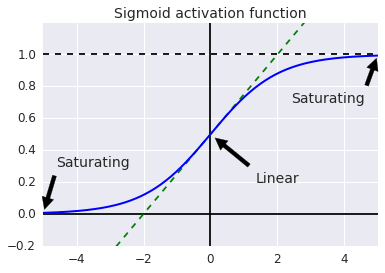

In [5]:
z = np.linspace(-5, 5, 200)

plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [1, 1], 'k--')
plt.plot([0, 0], [-0.2, 1.2], 'k-')
plt.plot([-5, 5], [-3/4, 7/4], 'g--')
plt.plot(z, logit(z), "b-", linewidth=2)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Saturating', xytext=(3.5, 0.7), xy=(5, 1), arrowprops=props, fontsize=14, ha="center")
plt.annotate('Saturating', xytext=(-3.5, 0.3), xy=(-5, 0), arrowprops=props, fontsize=14, ha="center")
plt.annotate('Linear', xytext=(2, 0.2), xy=(0, 0.5), arrowprops=props, fontsize=14, ha="center")
plt.grid(True)
plt.title("Sigmoid activation function", fontsize=14)
plt.axis([-5, 5, -0.2, 1.2])

#save_fig("sigmoid_saturation_plot")
plt.show()

# Xavier and He
Note: It is now preferable to use tf.layers.dense(), because anything in the contrib module may change or be deleted without notice. The dense() function is almost identical to the fully_connected() function. The main differences relevant to this chapter are:

several parameters are renamed: scope becomes name, activation_fn becomes activation (and similarly the _fn suffix is removed from other parameters such as normalizer_fn), weights_initializer becomes kernel_initializer, etc.
the default activation is now None rather than tf.nn.relu.
it does not support tensorflow.contrib.framework.arg_scope() (introduced later in chapter 11).
it does not support regularizer params (introduced later in chapter 11).

In [5]:
import tensorflow as tf
import numpy as np

In [6]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")

In [7]:
he_init = tf.contrib.layers.variance_scaling_initializer()
hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu,
                          kernel_initializer=he_init, name="hidden1")

In [8]:
init = tf.global_variables_initializer()
with tf.Session() as sess:
    init.run()
    Q=sess.run(hidden1, feed_dict={X:np.random.random(size=(1,28*28))})

# Nonsaturating Activation Functions
Leaky ReLU

In [9]:
def leaky_relu(z, alpha=0.01):
    return np.maximum(alpha*z, z)

In [10]:
plt.plot(z, leaky_relu(z, 0.05), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([0, 0], [-0.5, 4.2], 'k-')
plt.grid(True)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Leak', xytext=(-3.5, 0.5), xy=(-5, -0.2), arrowprops=props, fontsize=14, ha="center")
plt.title("Leaky ReLU activation function", fontsize=14)
plt.axis([-5, 5, -0.5, 4.2])


plt.show()

NameError: name 'z' is not defined

With this activation function, within 10 iteration, the neuron dies out with zero std deviation.

In [11]:
import time
np.random.seed(np.int32(time.time()))
Z = np.random.normal(size=(500, 100))
for layer in range(100):
    W = np.random.normal(size=(100, 100), scale=np.sqrt(2/200))
    Z = leaky_relu(np.dot(Z, W))
    means = np.mean(Z, axis=1)
    stds = np.std(Z, axis=1)
    if layer % 10 == 0:
        print("Layer {}: {:.2f} < mean < {:.2f}, {:.2f} < std deviation < {:.2f}".format(
            layer, means.min(), means.max(), stds.min(), stds.max()))

Layer 0: 0.20 < mean < 0.64, 0.35 < std deviation < 0.82
Layer 10: 0.00 < mean < 0.03, 0.01 < std deviation < 0.04
Layer 20: 0.00 < mean < 0.00, 0.00 < std deviation < 0.00
Layer 30: 0.00 < mean < 0.00, 0.00 < std deviation < 0.00
Layer 40: 0.00 < mean < 0.00, 0.00 < std deviation < 0.00
Layer 50: 0.00 < mean < 0.00, 0.00 < std deviation < 0.00
Layer 60: 0.00 < mean < 0.00, 0.00 < std deviation < 0.00
Layer 70: 0.00 < mean < 0.00, 0.00 < std deviation < 0.00
Layer 80: 0.00 < mean < 0.00, 0.00 < std deviation < 0.00
Layer 90: 0.00 < mean < 0.00, 0.00 < std deviation < 0.00


Implementing Leaky ReLU in TensorFlow:

In [12]:
reset_graph()

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")

In [13]:
def leaky_relu(z, name=None):
    return tf.maximum(0.01 * z, z, name=name)

hidden1 = tf.layers.dense(X, n_hidden1, activation=leaky_relu, name="hidden1")

Let's train a neural network on MNIST using the Leaky ReLU. First let's create the graph:

In [92]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300
n_hidden2 = 100
n_outputs = 10

In [93]:
X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int64, shape=(None), name="y")

In [94]:
with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=leaky_relu, name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=leaky_relu, name="hidden2")
    logits = tf.layers.dense(hidden2, n_outputs, name="outputs")

In [95]:
with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

In [96]:
learning_rate = 0.01

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

In [127]:
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    lr = tf.argmax(logits,1)
    correct2=tf.equal(lr,y)
    accuracy = tf.reduce_mean(tf.cast(correct2, tf.float32))

In [99]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [100]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/")

Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


In [101]:
def plot_image(image, shape=[28, 28]):
    plt.imshow(image.reshape(shape), cmap="Greys", interpolation="nearest")
    plt.axis("off")

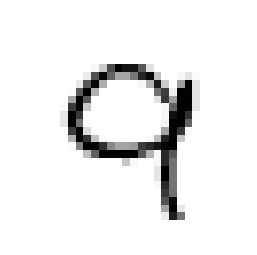

In [68]:
X_batch, y_batch = mnist.train.next_batch(100)
plot_image(X_batch[0])

In [69]:
#show label distribution statistics
countY = np.bincount(y_batch.reshape(-1))

In [70]:
countY

array([11, 18, 10,  6, 11,  9,  5, 12,  9,  9])

In [71]:
index=np.reshape(np.nonzero(countY),(-1))

In [72]:
[(x,y) for x,y in zip(index,countY[index]) ] 

[(0, 11),
 (1, 18),
 (2, 10),
 (3, 6),
 (4, 11),
 (5, 9),
 (6, 5),
 (7, 12),
 (8, 9),
 (9, 9)]

In [128]:
batch_size = 10
with tf.Session() as sess:
    init.run()
    X_batch, y_batch = mnist.train.next_batch(batch_size)
    sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
    logits_,y_,correct_,lr_,correct2_ = sess.run( (logits,y,correct,lr,correct2), feed_dict={X: X_batch, y: y_batch})
    

In [119]:
np.argmax(logits_,1)

array([1, 4, 3, 6, 0, 1, 1, 6, 0, 0])

In [120]:
lr_

array([1, 4, 3, 6, 0, 1, 1, 6, 0, 0])

In [121]:
y_

array([6, 7, 1, 0, 8, 1, 6, 0, 5, 1])

In [122]:
correct_

array([False, False, False, False, False,  True, False, False, False, False], dtype=bool)

In [123]:
correct2_

array([False, False, False, False, False,  True, False, False, False, False], dtype=bool)

In [126]:
np.equal(np.argmax(logits_,1),y_)

array([False, False, False, False, False,  True, False, False, False, False], dtype=bool)

In [129]:
n_epochs = 40
batch_size = 50

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(mnist.train.num_examples // batch_size):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        if epoch % 5 == 0:
            acc_train = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
            acc_test = accuracy.eval(feed_dict={X: mnist.validation.images, y: mnist.validation.labels})
            print(epoch, "Batch accuracy:", acc_train, "Validation accuracy:", acc_test)

    save_path = saver.save(sess, "./my_model_final.ckpt")

0 Batch accuracy: 0.96 Validation accuracy: 0.9004
5 Batch accuracy: 0.96 Validation accuracy: 0.95
10 Batch accuracy: 0.94 Validation accuracy: 0.9626
15 Batch accuracy: 0.94 Validation accuracy: 0.9716
20 Batch accuracy: 0.98 Validation accuracy: 0.9752
25 Batch accuracy: 0.98 Validation accuracy: 0.977
30 Batch accuracy: 1.0 Validation accuracy: 0.978
35 Batch accuracy: 0.98 Validation accuracy: 0.9798


# ELU

In [24]:
def elu(z, alpha=1):
    return np.where(z < 0, alpha * (np.exp(z) - 1), z)

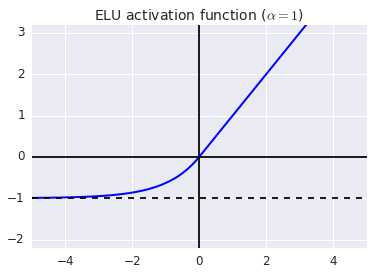

In [25]:
plt.plot(z, elu(z), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1, -1], 'k--')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.title(r"ELU activation function ($\alpha=1$)", fontsize=14)
plt.axis([-5, 5, -2.2, 3.2])

plt.show()

With this activation function, after a 10 layer deep neural network, neuron dies out with zero deviation

In [26]:
import time
np.random.seed(np.int32(time.time()))
Z = np.random.normal(size=(500, 100))
for layer in range(100):
    W = np.random.normal(size=(100, 100), scale=np.sqrt(2/200))
    Z = elu(np.dot(Z, W))
    means = np.mean(Z, axis=1)
    stds = np.std(Z, axis=1)
    if layer % 10 == 0:
        print("Layer {}: {:.2f} < mean < {:.2f}, {:.2f} < std deviation < {:.2f}".format(
            layer, means.min(), means.max(), stds.min(), stds.max()))

Layer 0: -0.07 < mean < 0.43, 0.53 < std deviation < 1.01
Layer 10: -0.04 < mean < 0.11, 0.11 < std deviation < 0.32
Layer 20: -0.02 < mean < 0.04, 0.07 < std deviation < 0.18
Layer 30: -0.01 < mean < 0.01, 0.03 < std deviation < 0.10
Layer 40: -0.00 < mean < 0.01, 0.02 < std deviation < 0.08
Layer 50: -0.01 < mean < 0.01, 0.01 < std deviation < 0.07
Layer 60: -0.00 < mean < 0.00, 0.01 < std deviation < 0.04
Layer 70: -0.00 < mean < 0.00, 0.01 < std deviation < 0.04
Layer 80: -0.00 < mean < 0.00, 0.00 < std deviation < 0.04
Layer 90: -0.00 < mean < 0.00, 0.00 < std deviation < 0.04


Implementing ELU in TensorFlow is trivial, just specify the activation function when building each layer:

In [27]:
reset_graph()

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")

In [28]:
hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.elu, name="hidden1")

In [29]:
init = tf.global_variables_initializer()
with tf.Session() as sess:
    init.run()
    Q=sess.run(hidden1, feed_dict={X:np.random.random(size=(1,28*28))})

# SELU

This activation function was proposed in this https://arxiv.org/pdf/1706.02515.pdf by Günter Klambauer, Thomas Unterthiner and Andreas Mayr, published in June 2017. It outperforms the other activation functions very significantly for deep neural networks, so you should really try it out.

In [30]:
def elu(z, alpha=1):
    return np.where(z < 0, alpha * (np.exp(z) - 1), z)
def selu(z,
         scale=1.0507009873554804934193349852946,
         alpha=1.6732632423543772848170429916717):
    return scale * elu(z, alpha)
    

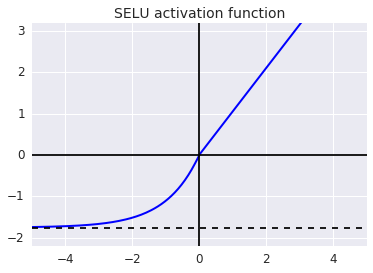

In [31]:
reset_graph()
z = np.linspace(-5, 5, 200)
#plt.plot(z, selu(z,0.05), "b-", linewidth=2)
plt.plot(z, selu(z), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1.758, -1.758], 'k--')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.title(r"SELU activation function", fontsize=14)
plt.axis([-5, 5, -2.2, 3.2])

plt.show()

With this activation function, even a 100 layer deep neural network preserves roughly mean 0 and standard deviation 1 across all layers, avoiding the exploding/vanishing gradients problem:

In [32]:
import time
np.random.seed(np.int32(time.time()))
Z = np.random.normal(size=(500, 100))
for layer in range(100):
    W = np.random.normal(size=(100, 100), scale=np.sqrt(2/200))
    Z = selu(np.dot(Z, W))
    means = np.mean(Z, axis=1)
    stds = np.std(Z, axis=1)
    if layer % 10 == 0:
        print("Layer {}: {:.2f} < mean < {:.2f}, {:.2f} < std deviation < {:.2f}".format(
            layer, means.min(), means.max(), stds.min(), stds.max()))

Layer 0: -0.32 < mean < 0.34, 0.72 < std deviation < 1.23
Layer 10: -0.33 < mean < 0.33, 0.70 < std deviation < 1.26
Layer 20: -0.19 < mean < 0.27, 0.82 < std deviation < 1.40
Layer 30: -0.26 < mean < 0.25, 0.66 < std deviation < 1.17
Layer 40: -0.16 < mean < 0.12, 0.71 < std deviation < 1.23
Layer 50: -0.26 < mean < 0.30, 0.69 < std deviation < 1.25
Layer 60: -0.19 < mean < 0.17, 0.75 < std deviation < 1.30
Layer 70: -0.24 < mean < 0.23, 0.73 < std deviation < 1.26
Layer 80: -0.28 < mean < 0.23, 0.74 < std deviation < 1.20
Layer 90: -0.18 < mean < 0.13, 0.74 < std deviation < 1.19


In [33]:
reset_graph()

def selu(z,
         scale=1.0507009873554804934193349852946,
         alpha=1.6732632423543772848170429916717):
    return scale * tf.where(z >= 0.0, z, alpha * tf.nn.elu(z))

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300
n_hidden2 = 100
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int64, shape=(None), name="y")


    
with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=selu, name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=selu, name="hidden2")
    logits = tf.layers.dense(hidden2, n_outputs, name="outputs")

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

learning_rate = 0.01

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()
saver = tf.train.Saver()
n_epochs = 40
batch_size = 50

In [34]:
means = mnist.train.images.mean(axis=0, keepdims=True)
stds = mnist.train.images.std(axis=0, keepdims=True) + 1e-10

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(mnist.train.num_examples // batch_size):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            X_batch_scaled = (X_batch - means) / stds
            sess.run(training_op, feed_dict={X: X_batch_scaled, y: y_batch})
        if epoch % 5 == 0:
            acc_train = accuracy.eval(feed_dict={X: X_batch_scaled, y: y_batch})
            X_val_scaled = (mnist.validation.images - means) / stds
            acc_test = accuracy.eval(feed_dict={X: X_val_scaled, y: mnist.validation.labels})
            print(epoch, "Batch accuracy:", acc_train, "Validation accuracy:", acc_test)

    save_path = saver.save(sess, "./my_model_final_selu.ckpt")

0 Batch accuracy: 0.96 Validation accuracy: 0.924
5 Batch accuracy: 1.0 Validation accuracy: 0.9568
10 Batch accuracy: 0.94 Validation accuracy: 0.967
15 Batch accuracy: 0.98 Validation accuracy: 0.9684
20 Batch accuracy: 1.0 Validation accuracy: 0.9712
25 Batch accuracy: 1.0 Validation accuracy: 0.9692
30 Batch accuracy: 1.0 Validation accuracy: 0.9698
35 Batch accuracy: 1.0 Validation accuracy: 0.971


# Batch normalization
Adding input data normalization of shift and scale at each layer

In [35]:
reset_graph()

import tensorflow as tf

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 100
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")

training = tf.placeholder_with_default(False, shape=(), name='training')

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, name="hidden1")
    bn1 = tf.layers.batch_normalization(hidden1, training=training, momentum=0.9)
    bn1_act = tf.nn.elu(bn1)

    hidden2 = tf.layers.dense(bn1_act, n_hidden2, name="hidden2")
    bn2 = tf.layers.batch_normalization(hidden2, training=training, momentum=0.9)
    bn2_act = tf.nn.elu(bn2)

    logits_before_bn = tf.layers.dense(bn2_act, n_outputs, name="outputs")
    logits = tf.layers.batch_normalization(logits_before_bn, training=training,
                                           momentum=0.9)

To avoid repeating the same parameters over and over again, we can use Python's partial() function:

In [36]:
reset_graph()

import tensorflow as tf

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 100
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
training = tf.placeholder_with_default(False, shape=(), name='training')


from functools import partial





with tf.name_scope("dnn"):
    my_batch_norm_layer = partial(tf.layers.batch_normalization,
                              training=training, momentum=0.9)
    hidden1 = tf.layers.dense(X, n_hidden1, name="hidden1")
    bn1 = my_batch_norm_layer(hidden1)
    bn1_act = tf.nn.elu(bn1)
    hidden2 = tf.layers.dense(bn1_act, n_hidden2, name="hidden2")
    bn2 = my_batch_norm_layer(hidden2)
    bn2_act = tf.nn.elu(bn2)
    logits_before_bn = tf.layers.dense(bn2_act, n_outputs, name="outputs")
    logits = my_batch_norm_layer(logits_before_bn)



Let's build a neural net for MNIST, using the ELU activation function and Batch Normalization at each layer:

In [37]:
reset_graph()

batch_norm_momentum = 0.9

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int64, shape=(None), name="y")
training = tf.placeholder_with_default(False, shape=(), name='training')

with tf.name_scope("dnn"):
    he_init = tf.contrib.layers.variance_scaling_initializer()

    my_batch_norm_layer = partial(
            tf.layers.batch_normalization,
            training=training,
            momentum=batch_norm_momentum)

    my_dense_layer = partial(
            tf.layers.dense,
            kernel_initializer=he_init)

    hidden1 = my_dense_layer(X, n_hidden1, name="hidden1")
    bn1 = tf.nn.elu(my_batch_norm_layer(hidden1))
    hidden2 = my_dense_layer(bn1, n_hidden2, name="hidden2")
    bn2 = tf.nn.elu(my_batch_norm_layer(hidden2))
    logits_before_bn = my_dense_layer(bn2, n_outputs, name="outputs")
    logits = my_batch_norm_layer(logits_before_bn)

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
    
init = tf.global_variables_initializer()
saver = tf.train.Saver()

Note: since we are using tf.layers.batch_normalization() rather than tf.contrib.layers.batch_norm(), we need to explicitly run the extra update operations needed by batch normalization (sess.run([training_op, extra_update_ops],...).

In [38]:
n_epochs = 20
batch_size = 200

extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)

file_writer = tf.summary.FileWriter("./model/batch_norm", tf.get_default_graph())
file_writer.close()
    
with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(mnist.train.num_examples // batch_size):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run([training_op, extra_update_ops],
                     feed_dict={training: True, X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: mnist.test.images,
                                                y: mnist.test.labels})
        print(epoch, "Test accuracy:", accuracy_val)
    save_path = saver.save(sess, "./model/my_model_deepLearning_batch_norm_final.ckpt")

0 Test accuracy: 0.8652
1 Test accuracy: 0.8961
2 Test accuracy: 0.9122
3 Test accuracy: 0.9222
4 Test accuracy: 0.929
5 Test accuracy: 0.9351
6 Test accuracy: 0.9379
7 Test accuracy: 0.9435
8 Test accuracy: 0.9451
9 Test accuracy: 0.9485
10 Test accuracy: 0.951
11 Test accuracy: 0.9532
12 Test accuracy: 0.9555
13 Test accuracy: 0.9576
14 Test accuracy: 0.9597
15 Test accuracy: 0.9609
16 Test accuracy: 0.9615
17 Test accuracy: 0.9634
18 Test accuracy: 0.9641
19 Test accuracy: 0.965


In [39]:
[v.name for v in tf.trainable_variables()]

['hidden1/kernel:0',
 'hidden1/bias:0',
 'batch_normalization/gamma:0',
 'batch_normalization/beta:0',
 'hidden2/kernel:0',
 'hidden2/bias:0',
 'batch_normalization_1/gamma:0',
 'batch_normalization_1/beta:0',
 'outputs/kernel:0',
 'outputs/bias:0',
 'batch_normalization_2/gamma:0',
 'batch_normalization_2/beta:0']

In [40]:
[v.name for v in tf.global_variables()]

['hidden1/kernel:0',
 'hidden1/bias:0',
 'batch_normalization/gamma:0',
 'batch_normalization/beta:0',
 'batch_normalization/moving_mean:0',
 'batch_normalization/moving_variance:0',
 'hidden2/kernel:0',
 'hidden2/bias:0',
 'batch_normalization_1/gamma:0',
 'batch_normalization_1/beta:0',
 'batch_normalization_1/moving_mean:0',
 'batch_normalization_1/moving_variance:0',
 'outputs/kernel:0',
 'outputs/bias:0',
 'batch_normalization_2/gamma:0',
 'batch_normalization_2/beta:0',
 'batch_normalization_2/moving_mean:0',
 'batch_normalization_2/moving_variance:0']

# Reusing Pretrained Layers

# Reusing a TensorFlow Model

First you need to load the graph's structure. The import_meta_graph() function does just that, loading the graph's operations into the default graph, and returning a Saver that you can then use to restore the model's state. Note that by default, a Saver saves the structure of the graph into a .meta file, so that's the file you should load:

In [41]:
reset_graph()

In [42]:
saver = tf.train.import_meta_graph("./model/my_model_deepLearning_batch_norm_final.ckpt.meta")

In [43]:
X = tf.get_default_graph().get_tensor_by_name("X:0")
y = tf.get_default_graph().get_tensor_by_name("y:0")
training = tf.get_default_graph().get_tensor_by_name("training:0")
accuracy = tf.get_default_graph().get_tensor_by_name("eval/Mean:0")

training_op = tf.get_default_graph().get_operation_by_name("train/GradientDescent")

In [44]:
for op in (X, y, training, accuracy, training_op):
    tf.add_to_collection("my_important_ops2", op)

This way people who reuse your model will be able to simply write:

In [45]:
X, y, training, accuracy, training_op = tf.get_collection("my_important_ops2")

In [46]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/")

Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


Now you can start a session, restore the model's state and continue training on your data:

with tf.Session() as sess:
    saver.restore(sess, "./model/my_model_deepLearning_batch_norm_final.ckpt")
    # continue training the model...

In [47]:
n_epochs = 20
batch_size = 200
acc_summary = tf.summary.scalar('Accuracy', accuracy)

file_writer = tf.summary.FileWriter("./model_reuse/batch_norm", tf.get_default_graph())

#saver = tf.train.import_meta_graph("./model/my_model_deepLearning_batch_norm_final.ckpt.meta")
with tf.Session() as sess:
    saver.restore(sess, "./model/my_model_deepLearning_batch_norm_final.ckpt")

    for epoch in range(n_epochs):
        for iteration in range(mnist.train.num_examples // batch_size):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={training: True, X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: mnist.test.images,
                                                y: mnist.test.labels})
        
        summary_str = acc_summary.eval(feed_dict={X: mnist.test.images,
                                                y: mnist.test.labels})
        file_writer.add_summary(summary_str, epoch)
        print(epoch, "Test accuracy:", accuracy_val)

    save_path = saver.save(sess, "./model_reuse/my_model_deepLearning_batch_norm_final.ckpt")  
    file_writer.close()

INFO:tensorflow:Restoring parameters from ./model/my_model_deepLearning_batch_norm_final.ckpt
[2018-02-19 03:26:22,574] {tf_logging.py:82} INFO - Restoring parameters from ./model/my_model_deepLearning_batch_norm_final.ckpt
0 Test accuracy: 0.9657
1 Test accuracy: 0.9661
2 Test accuracy: 0.9674
3 Test accuracy: 0.9672
4 Test accuracy: 0.9682
5 Test accuracy: 0.9682
6 Test accuracy: 0.9685
7 Test accuracy: 0.9688
8 Test accuracy: 0.9692
9 Test accuracy: 0.9691
10 Test accuracy: 0.9695
11 Test accuracy: 0.9688
12 Test accuracy: 0.9688
13 Test accuracy: 0.9696
14 Test accuracy: 0.9695
15 Test accuracy: 0.9695
16 Test accuracy: 0.9689
17 Test accuracy: 0.9689
18 Test accuracy: 0.9693
19 Test accuracy: 0.9695


Use the most simple one "my_model_final"

In general you will want to reuse only the lower layers. If you are using import_meta_graph() it will load the whole graph, but you can simply ignore the parts you do not need. In this example, we add a new 4th hidden layer on top of the pretrained 3rd layer (ignoring the old 4th hidden layer). We also build a new output layer, the loss for this new output, and a new optimizer to minimize it. We also need another saver to save the whole graph (containing both the entire old graph plus the new operations), and an initialization operation to initialize all the new variables:

Re-define the model first

In [48]:
def leaky_relu(z, name=None):
    return tf.maximum(0.01 * z, z, name=name)

In [49]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300
n_hidden2 = 50
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int64, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=leaky_relu, name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=leaky_relu, name="hidden2")
    logits = tf.layers.dense(hidden2, n_outputs, name="outputs")
    
with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")
    
learning_rate = 0.01

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)
    
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
    
init = tf.global_variables_initializer()
saver = tf.train.Saver()

from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/")

n_epochs = 40
batch_size = 50

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(mnist.train.num_examples // batch_size):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        if epoch % 5 == 0:
            acc_train = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
            acc_test = accuracy.eval(feed_dict={X: mnist.validation.images, y: mnist.validation.labels})
            print(epoch, "Batch accuracy:", acc_train, "Validation accuracy:", acc_test)

    save_path = saver.save(sess, "./my_model_final.ckpt")

Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz
0 Batch accuracy: 0.9 Validation accuracy: 0.9032
5 Batch accuracy: 0.88 Validation accuracy: 0.9504
10 Batch accuracy: 0.98 Validation accuracy: 0.964
15 Batch accuracy: 1.0 Validation accuracy: 0.971
20 Batch accuracy: 1.0 Validation accuracy: 0.976
25 Batch accuracy: 1.0 Validation accuracy: 0.9772
30 Batch accuracy: 1.0 Validation accuracy: 0.978
35 Batch accuracy: 0.98 Validation accuracy: 0.9796


# Define a new model
# Freezing a lower layer

In [50]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300 # reused
n_hidden2 = 50  # reused
n_hidden3 = 50  # new!
n_hidden4 = 20  # new!
n_outputs = 10  # new!
learning_rate = 0.01
X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int64, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")       # reused
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, name="hidden2") # reused
    hidden3 = tf.layers.dense(hidden2, n_hidden3, activation=tf.nn.relu, name="hidden3") # reused
    hidden4 = tf.layers.dense(hidden3, n_hidden4, activation=tf.nn.relu, name="hidden4") # new!
    logits = tf.layers.dense(hidden4, n_outputs, name="outputs")                         # new!

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")
    
with tf.name_scope("train"):                                         # not shown in the book
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)     # not shown
    train_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,
                                   scope="hidden[34]|outputs")
    training_op = optimizer.minimize(loss, var_list=train_vars)
    
init = tf.global_variables_initializer()
new_saver = tf.train.Saver()

reuse_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES,
                               scope="hidden[12]") # regular expression
reuse_vars_dict = dict([(var.op.name, var) for var in reuse_vars])
restore_saver = tf.train.Saver(reuse_vars_dict) # to restore layers 1-2

init = tf.global_variables_initializer()
saver = tf.train.Saver()
n_epochs = 20
batch_size = 50
with tf.Session() as sess:
    init.run()
    restore_saver.restore(sess, "./my_model_final.ckpt")

    for epoch in range(n_epochs):
        for iteration in range(mnist.train.num_examples // batch_size):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: mnist.test.images,
                                                y: mnist.test.labels})
        print(epoch, "Test accuracy:", accuracy_val)

    save_path = saver.save(sess, "./my_new_model_final.ckpt")

INFO:tensorflow:Restoring parameters from ./my_model_final.ckpt
[2018-02-19 03:34:15,578] {tf_logging.py:82} INFO - Restoring parameters from ./my_model_final.ckpt
0 Test accuracy: 0.9617
1 Test accuracy: 0.9675
2 Test accuracy: 0.9705
3 Test accuracy: 0.9721
4 Test accuracy: 0.9733
5 Test accuracy: 0.9742
6 Test accuracy: 0.9741
7 Test accuracy: 0.9743
8 Test accuracy: 0.9734
9 Test accuracy: 0.9745
10 Test accuracy: 0.9755
11 Test accuracy: 0.9747
12 Test accuracy: 0.9741
13 Test accuracy: 0.9749
14 Test accuracy: 0.9757
15 Test accuracy: 0.9753
16 Test accuracy: 0.9755
17 Test accuracy: 0.9755
18 Test accuracy: 0.9744
19 Test accuracy: 0.9754


In [51]:
reuse_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES,
                               scope="hidden[123]") # regular expression
reuse_vars_dict = dict([(var.op.name, var) for var in reuse_vars])
restore_saver = tf.train.Saver(reuse_vars_dict) # to restore layers 1-3

init = tf.global_variables_initializer()
saver = tf.train.Saver()

with tf.Session() as sess:
    init.run()
    restore_saver.restore(sess, "./my_new_model_final.ckpt")

    for epoch in range(n_epochs):
        for iteration in range(mnist.train.num_examples // batch_size):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: mnist.test.images,
                                                y: mnist.test.labels})
        print(epoch, "Test accuracy:", accuracy_val)

    save_path = saver.save(sess, "./my_new_model_final.ckpt")

INFO:tensorflow:Restoring parameters from ./my_new_model_final.ckpt
[2018-02-19 03:35:10,818] {tf_logging.py:82} INFO - Restoring parameters from ./my_new_model_final.ckpt
0 Test accuracy: 0.9714
1 Test accuracy: 0.974
2 Test accuracy: 0.9752
3 Test accuracy: 0.976
4 Test accuracy: 0.9757
5 Test accuracy: 0.9743
6 Test accuracy: 0.9747
7 Test accuracy: 0.9755
8 Test accuracy: 0.9756
9 Test accuracy: 0.9759
10 Test accuracy: 0.9754
11 Test accuracy: 0.977
12 Test accuracy: 0.9765
13 Test accuracy: 0.9761
14 Test accuracy: 0.9759
15 Test accuracy: 0.976
16 Test accuracy: 0.9756
17 Test accuracy: 0.9759
18 Test accuracy: 0.9762
19 Test accuracy: 0.9755


# Caching the frozen layer

In [52]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300 # reused
n_hidden2 = 50  # reused
n_hidden3 = 50  # reused
n_hidden4 = 20  # new!
n_outputs = 10  # new!

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int64, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu,
                              name="hidden1") # reused frozen
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu,
                              name="hidden2") # reused frozen & cached
    hidden2_stop = tf.stop_gradient(hidden2)
    hidden3 = tf.layers.dense(hidden2_stop, n_hidden3, activation=tf.nn.relu,
                              name="hidden3") # reused, not frozen
    hidden4 = tf.layers.dense(hidden3, n_hidden4, activation=tf.nn.relu,
                              name="hidden4") # new!
    logits = tf.layers.dense(hidden4, n_outputs, name="outputs") # new!

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

reuse_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES,
                               scope="hidden[123]") # regular expression
reuse_vars_dict = dict([(var.op.name, var) for var in reuse_vars])
restore_saver = tf.train.Saver(reuse_vars_dict) # to restore layers 1-3

init = tf.global_variables_initializer()
saver = tf.train.Saver()
import numpy as np

n_batches = mnist.train.num_examples // batch_size

with tf.Session() as sess:
    init.run()
    restore_saver.restore(sess, "./my_new_model_final.ckpt")
    
    h2_cache = sess.run(hidden2, feed_dict={X: mnist.train.images})
    h2_cache_test = sess.run(hidden2, feed_dict={X: mnist.test.images}) # not shown in the book

    for epoch in range(n_epochs):
        shuffled_idx = np.random.permutation(mnist.train.num_examples)
        hidden2_batches = np.array_split(h2_cache[shuffled_idx], n_batches)
        y_batches = np.array_split(mnist.train.labels[shuffled_idx], n_batches)
        for hidden2_batch, y_batch in zip(hidden2_batches, y_batches):
            sess.run(training_op, feed_dict={hidden2:hidden2_batch, y:y_batch})

        accuracy_val = accuracy.eval(feed_dict={hidden2: h2_cache_test, # not shown
                                                y: mnist.test.labels})  # not shown
        print(epoch, "Test accuracy:", accuracy_val)                    # not shown

    save_path = saver.save(sess, "./my_new_model_final2.ckpt")

INFO:tensorflow:Restoring parameters from ./my_new_model_final.ckpt
[2018-02-19 03:36:07,152] {tf_logging.py:82} INFO - Restoring parameters from ./my_new_model_final.ckpt
0 Test accuracy: 0.9691
1 Test accuracy: 0.9717
2 Test accuracy: 0.9741
3 Test accuracy: 0.9738
4 Test accuracy: 0.9745
5 Test accuracy: 0.9752
6 Test accuracy: 0.9755
7 Test accuracy: 0.9753
8 Test accuracy: 0.9758
9 Test accuracy: 0.9753
10 Test accuracy: 0.9761
11 Test accuracy: 0.9762
12 Test accuracy: 0.9756
13 Test accuracy: 0.9774
14 Test accuracy: 0.9772
15 Test accuracy: 0.9752
16 Test accuracy: 0.9769
17 Test accuracy: 0.9767
18 Test accuracy: 0.9766
19 Test accuracy: 0.9765


# Avoiding Overfitting Through Regularization
ℓ1ℓ1  and ℓ2ℓ2 regularization


Let's implement  ℓ1ℓ1  regularization manually. First, we create the model, as usual (with just one hidden layer this time, for simplicity):

In [53]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int64, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")
    logits = tf.layers.dense(hidden1, n_outputs, name="outputs")

Next, we get a handle on the layer weights, and we compute the total loss, which is equal to the sum of the usual cross entropy loss and the  ℓ1ℓ1  loss (i.e., the absolute values of the weights):

In [54]:
W1 = tf.get_default_graph().get_tensor_by_name("hidden1/kernel:0")
W2 = tf.get_default_graph().get_tensor_by_name("outputs/kernel:0")

scale = 0.001 # l1 regularization hyperparameter

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y,
                                                              logits=logits)
    base_loss = tf.reduce_mean(xentropy, name="avg_xentropy")
    reg_losses = tf.reduce_sum(tf.abs(W1)) + tf.reduce_sum(tf.abs(W2))
    loss = tf.add(base_loss, scale * reg_losses, name="loss")

In [55]:
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

learning_rate = 0.01

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

n_epochs = 20
batch_size = 200

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(mnist.train.num_examples // batch_size):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: mnist.test.images,
                                                y: mnist.test.labels})
        print(epoch, "Test accuracy:", accuracy_val)

    save_path = saver.save(sess, "./my_model_reg.ckpt")

0 Test accuracy: 0.8348
1 Test accuracy: 0.8702
2 Test accuracy: 0.8814
3 Test accuracy: 0.8905
4 Test accuracy: 0.8964
5 Test accuracy: 0.8983
6 Test accuracy: 0.9006
7 Test accuracy: 0.903
8 Test accuracy: 0.9041
9 Test accuracy: 0.905
10 Test accuracy: 0.9063
11 Test accuracy: 0.9068
12 Test accuracy: 0.9062
13 Test accuracy: 0.9075
14 Test accuracy: 0.9078
15 Test accuracy: 0.9079
16 Test accuracy: 0.9069
17 Test accuracy: 0.9067
18 Test accuracy: 0.9059
19 Test accuracy: 0.9063


Alternatively, we can pass a regularization function to the tf.layers.dense() function, which will use it to create operations that will compute the regularization loss, and it adds these operations to the collection of regularization losses. The beginning is the same as above:

In [56]:
from functools import partial
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300
n_hidden2 = 50
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int64, shape=(None), name="y")

scale = 0.001 # l1 regularization hyperparameter

my_dense_layer = partial(
    tf.layers.dense, activation=tf.nn.relu,
    kernel_regularizer=tf.contrib.layers.l1_regularizer(scale))

with tf.name_scope("dnn"):
    hidden1 = my_dense_layer(X, n_hidden1, name="hidden1")
    hidden2 = my_dense_layer(hidden1, n_hidden2, name="hidden2")
    logits = my_dense_layer(hidden2, n_outputs, activation=None,
                            name="outputs")
#Next we must add the regularization losses to the base loss:
with tf.name_scope("loss"):                                     # not shown in the book
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(  # not shown
        labels=y, logits=logits)                                # not shown
    base_loss = tf.reduce_mean(xentropy, name="avg_xentropy")   # not shown
    reg_losses = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
    loss = tf.add_n([base_loss] + reg_losses, name="loss")
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

learning_rate = 0.01

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

n_epochs = 20
batch_size = 200

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(mnist.train.num_examples // batch_size):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: mnist.test.images,
                                                y: mnist.test.labels})
        print(epoch, "Test accuracy:", accuracy_val)

    save_path = saver.save(sess, "./my_model_reg2.ckpt")

0 Test accuracy: 0.8293
1 Test accuracy: 0.878
2 Test accuracy: 0.8924
3 Test accuracy: 0.9014
4 Test accuracy: 0.9061
5 Test accuracy: 0.91
6 Test accuracy: 0.913
7 Test accuracy: 0.9149
8 Test accuracy: 0.9158
9 Test accuracy: 0.9171
10 Test accuracy: 0.9171
11 Test accuracy: 0.918
12 Test accuracy: 0.9183
13 Test accuracy: 0.9197
14 Test accuracy: 0.9183
15 Test accuracy: 0.9191
16 Test accuracy: 0.9189
17 Test accuracy: 0.9177
18 Test accuracy: 0.919
19 Test accuracy: 0.918


# Drop out

In [57]:
reset_graph()
n_inputs = 28 * 28  # MNIST
n_hidden1 = 300
n_hidden2 = 50
n_outputs = 10
X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int64, shape=(None), name="y")

In [58]:
training = tf.placeholder_with_default(False, shape=(), name='training')

dropout_rate = 0.5  # == 1 - keep_prob
X_drop = tf.layers.dropout(X, dropout_rate, training=training)
learning_rate = 0.01
with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X_drop, n_hidden1, activation=tf.nn.relu,
                              name="hidden1")
    hidden1_drop = tf.layers.dropout(hidden1, dropout_rate, training=training)
    hidden2 = tf.layers.dense(hidden1_drop, n_hidden2, activation=tf.nn.relu,
                              name="hidden2")
    hidden2_drop = tf.layers.dropout(hidden2, dropout_rate, training=training)
    logits = tf.layers.dense(hidden2_drop, n_outputs, name="outputs")

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("train"):
    optimizer = tf.train.MomentumOptimizer(learning_rate, momentum=0.9)
    training_op = optimizer.minimize(loss)    

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
    
init = tf.global_variables_initializer()
saver = tf.train.Saver()

n_epochs = 20
batch_size = 50


with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(mnist.train.num_examples // batch_size):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={training: True, X: X_batch, y: y_batch})
        acc_test = accuracy.eval(feed_dict={X: mnist.test.images, y: mnist.test.labels})
        print(epoch, "Test accuracy:", acc_test)

    save_path = saver.save(sess, "./my_model_final.ckpt")

0 Test accuracy: 0.9237
1 Test accuracy: 0.9409
2 Test accuracy: 0.9486
3 Test accuracy: 0.9521
4 Test accuracy: 0.9559
5 Test accuracy: 0.9584
6 Test accuracy: 0.9593
7 Test accuracy: 0.9575
8 Test accuracy: 0.961
9 Test accuracy: 0.9619
10 Test accuracy: 0.9637
11 Test accuracy: 0.9636
12 Test accuracy: 0.9688
13 Test accuracy: 0.9667
14 Test accuracy: 0.9675
15 Test accuracy: 0.9685
16 Test accuracy: 0.9686
17 Test accuracy: 0.9697
18 Test accuracy: 0.9705
19 Test accuracy: 0.9694


# Max Norm

In [59]:
reset_graph()

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 50
n_outputs = 10

learning_rate = 0.01
momentum = 0.9

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int64, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, name="hidden2")
    logits = tf.layers.dense(hidden2, n_outputs, name="outputs")

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("train"):
    optimizer = tf.train.MomentumOptimizer(learning_rate, momentum)
    training_op = optimizer.minimize(loss)    

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
    
threshold = 1.0
weights = tf.get_default_graph().get_tensor_by_name("hidden1/kernel:0")
clipped_weights = tf.clip_by_norm(weights, clip_norm=threshold, axes=1)
clip_weights = tf.assign(weights, clipped_weights)

weights2 = tf.get_default_graph().get_tensor_by_name("hidden2/kernel:0")
clipped_weights2 = tf.clip_by_norm(weights2, clip_norm=threshold, axes=1)
clip_weights2 = tf.assign(weights2, clipped_weights2)

init = tf.global_variables_initializer()
saver = tf.train.Saver()
n_epochs = 20
batch_size = 50

with tf.Session() as sess:                                              # not shown in the book
    init.run()                                                          # not shown
    for epoch in range(n_epochs):                                       # not shown
        for iteration in range(mnist.train.num_examples // batch_size):  # not shown
            X_batch, y_batch = mnist.train.next_batch(batch_size)       # not shown
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
            clip_weights.eval()
            clip_weights2.eval()                                        # not shown
        acc_test = accuracy.eval(feed_dict={X: mnist.test.images,       # not shown
                                            y: mnist.test.labels})      # not shown
        print(epoch, "Test accuracy:", acc_test)                        # not shown

    save_path = saver.save(sess, "./my_model_final.ckpt")               # not shown

0 Test accuracy: 0.9559
1 Test accuracy: 0.9676
2 Test accuracy: 0.9732
3 Test accuracy: 0.9742
4 Test accuracy: 0.974
5 Test accuracy: 0.9775
6 Test accuracy: 0.9801
7 Test accuracy: 0.9791
8 Test accuracy: 0.9755
9 Test accuracy: 0.9817
10 Test accuracy: 0.9803
11 Test accuracy: 0.977
12 Test accuracy: 0.9802
13 Test accuracy: 0.9814
14 Test accuracy: 0.9811
15 Test accuracy: 0.9827
16 Test accuracy: 0.9824
17 Test accuracy: 0.983
18 Test accuracy: 0.9826
19 Test accuracy: 0.9832


In [60]:
#show_graph(tf.get_default_graph())


The implementation above is straightforward and it works fine, but it is a bit messy. A better approach is to define a max_norm_regularizer() function:

In [61]:
def max_norm_regularizer(threshold, axes=1, name="max_norm",
                         collection="max_norm"):
    def max_norm(weights):
        clipped = tf.clip_by_norm(weights, clip_norm=threshold, axes=axes)
        clip_weights = tf.assign(weights, clipped, name=name)
        tf.add_to_collection(collection, clip_weights)
        return None # there is no regularization loss term
    return max_norm

Then you can call this function to get a max norm regularizer (with the threshold you want). When you create a hidden layer, you can pass this regularizer to the kernel_regularizer argument:

In [62]:
reset_graph()

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 50
n_outputs = 10

learning_rate = 0.01
momentum = 0.9

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int64, shape=(None), name="y")
max_norm_reg = max_norm_regularizer(threshold=1.0)

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu,
                              kernel_regularizer=max_norm_reg, name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu,
                              kernel_regularizer=max_norm_reg, name="hidden2")
    logits = tf.layers.dense(hidden2, n_outputs, name="outputs")
with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("train"):
    optimizer = tf.train.MomentumOptimizer(learning_rate, momentum)
    training_op = optimizer.minimize(loss)    

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()
saver = tf.train.Saver()
n_epochs = 20
batch_size = 50

clip_all_weights = tf.get_collection("max_norm")

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(mnist.train.num_examples // batch_size):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
            sess.run(clip_all_weights)
        acc_test = accuracy.eval(feed_dict={X: mnist.test.images,     # not shown in the book
                                            y: mnist.test.labels})    # not shown
        print(epoch, "Test accuracy:", acc_test)                      # not shown

    save_path = saver.save(sess, "./my_model_final.ckpt")             # not shown

0 Test accuracy: 0.9549
1 Test accuracy: 0.971
2 Test accuracy: 0.9702
3 Test accuracy: 0.9656
4 Test accuracy: 0.972
5 Test accuracy: 0.9753
6 Test accuracy: 0.976
7 Test accuracy: 0.9777
8 Test accuracy: 0.9783
9 Test accuracy: 0.9782
10 Test accuracy: 0.9811
11 Test accuracy: 0.9776
12 Test accuracy: 0.9808
13 Test accuracy: 0.9801
14 Test accuracy: 0.9816
15 Test accuracy: 0.9813
16 Test accuracy: 0.9804
17 Test accuracy: 0.981
18 Test accuracy: 0.9819
19 Test accuracy: 0.9819
